[*********************100%***********************]  1 of 1 completed


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 753.8571
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 751.4889
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 749.2541
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 748.2603
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 747.3760
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 746.3427
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 745.6685
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 745.3466
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 744.7881
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 744.4991
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 744.2922
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 744.1592
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 744.0458
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 744.0123
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s

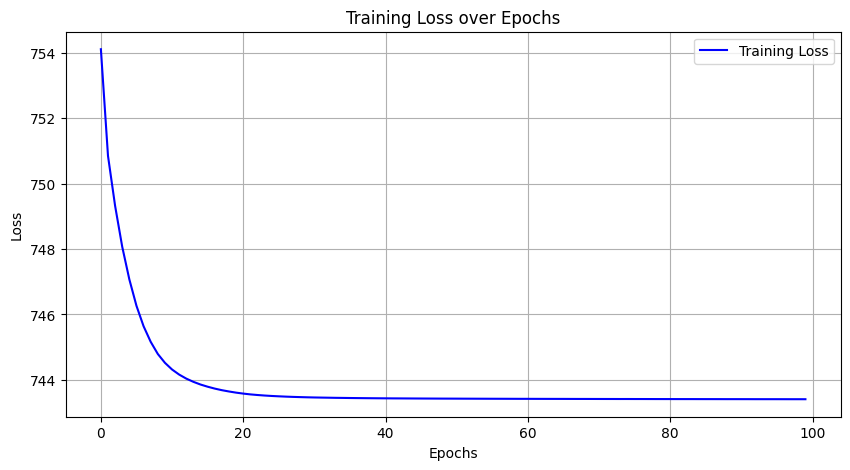

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error: 50.405853271484375


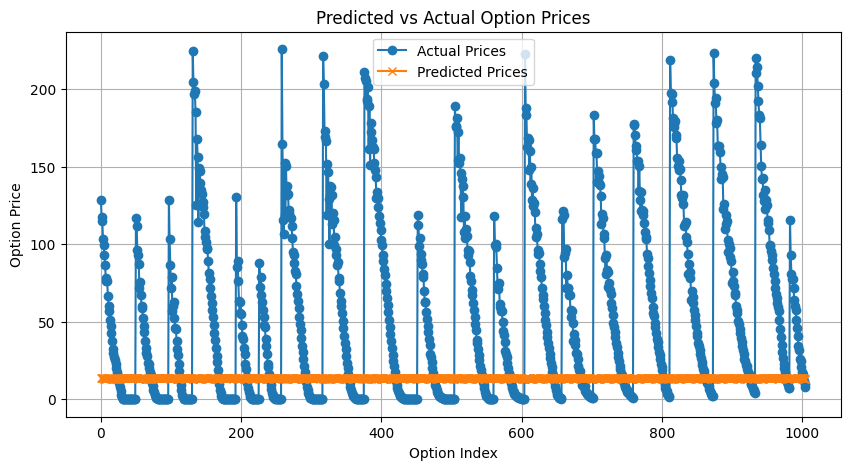

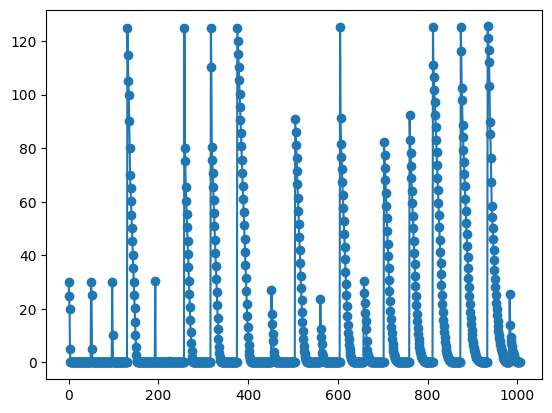

In [129]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
import matplotlib.pyplot as plt

# Black-Scholes formula for option pricing
def black_scholes(S, K, T, r, sigma, option_type='call'):
    # Handle cases where T <= 0
    T = np.where(T > 0, T, np.nan)  # Set non-positive T values to NaN

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        C = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    # Replace results where T was NaN with the intrinsic values
    C = np.where(np.isnan(T), np.maximum(S - K, 0) if option_type == 'call' else np.maximum(K - S, 0), C)

    return C


# Create the PINN model
def create_pinn():
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(5,)))  # 5 inputs: S, K, T, r, sigma
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Use ReLU to ensure non-negative outputs
    return model

# Custom loss function for the PINN
def loss_function(y_pred, S, K, T, r, sigma, lambda_=1.0):
    # Calculate Black-Scholes prices
    C_bs = black_scholes(S, K, T, r, sigma)  # Use variable T, r, sigma for each option
    L_bs = tf.reduce_mean(tf.square(C_bs - y_pred))

    # Early exercise condition
    intrinsic_value = tf.maximum(S - K, 0)
    L_exercise = tf.reduce_mean(tf.maximum(intrinsic_value - y_pred, 0))
    
    # Combine losses
    return L_bs + lambda_ * L_exercise


# Fetch historical data
def fetch_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)
    options = yf.Ticker(ticker).options

    option_data = []
    for expiration in options:
        calls = yf.Ticker(ticker).option_chain(expiration).calls
        puts = yf.Ticker(ticker).option_chain(expiration).puts
        option_data.append((expiration, calls, puts))

    return stock_data, option_data

# Prepare training data from the fetched options data
def prepare_training_data(option_data, stock_price):
    X_train = []
    y_train = []

    for expiration, calls, puts in option_data:
        for index, row in calls.iterrows():
            S = stock_price
            K = row['strike']
            T = (pd.to_datetime(expiration) - pd.to_datetime('today')).days / 365.0  # Convert days to years
            r = 0.05  # Assuming a constant risk-free rate
            sigma = 0.2  # Assume constant volatility for simplicity

            X_train.append([S, K, T, r, sigma])
            y_train.append(row['lastPrice'])  # Use the last market price of the call option

    return np.array(X_train, dtype=np.float32), np.array(y_train, dtype=np.float32)

# Fetching historical stock price and options data for a specific ticker
ticker = 'AAPL'  # Example: Apple Inc.
start_date = '2022-01-01'
end_date = '2023-01-01'

# Get stock data and options
stock_data, option_data = fetch_data(ticker, start_date, end_date)

# Get the latest stock price
latest_stock_price = stock_data['Close'].iloc[-1]

# Prepare training data
X_train, y_train = prepare_training_data(option_data, latest_stock_price)

# Create and compile the model
pinn_model = create_pinn()
# Compile the model with the updated loss function
pinn_model.compile(optimizer=Adam(learning_rate=1e-5), loss=lambda y_true, y_pred: 
    loss_function(y_pred, X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], X_train[:, 4]))

# Train the model
# Train the model and store the training history
history = pinn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)  # Adjust epochs as needed

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluate the model
def evaluate_model(option_data, stock_price):
    X_test = []
    y_test = []

    for expiration, calls, puts in option_data:
        for index, row in calls.iterrows():
            S = stock_price
            K = row['strike']
            T = (pd.to_datetime(expiration) - pd.to_datetime('today')).days / 365.0  # Convert days to years
            r = 0.05  # Assuming a constant risk-free rate
            sigma = 0.2  # Assume constant volatility for simplicity

            X_test.append([S, K, T, r, sigma])
            y_test.append(row['lastPrice'])

    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)

    # Make predictions
    y_pred = pinn_model.predict(X_test)

    # Calculate and print the mean absolute error
    mae = np.mean(np.abs(y_pred - y_test))
    print(f'Mean Absolute Error: {mae}')

    # Plotting predicted vs actual prices
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual Prices', marker='o')
    plt.plot(y_pred, label='Predicted Prices', marker='x')
    plt.title('Predicted vs Actual Option Prices')
    plt.xlabel('Option Index')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid()
    plt.show()

# Evaluate the trained model
evaluate_model(option_data, latest_stock_price)

plt.plot(black_scholes(X_test[:,0],X_test[:,1],X_test[:,2],X_test[:,3],X_test[:,4]),marker='o',label="Pure Black-Scholes")
